In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/CSV files/axis_day_data.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mean_data = df.loc[:, ['open', 'close']].mean(axis=1)
df['mean_data']=mean_data
# dataset=df[['date','mean_data']]
dataset=df[['mean_data']]
dataset = pd.DataFrame({'mean_data': mean_data, 'lag_1': mean_data.shift(1), 'lag_2': mean_data.shift(2)})
dataset = dataset.dropna()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
train=dataset.iloc[:-5]
test=dataset.iloc[-5:]

In [ ]:
# Define exogenous variables for training
exog_train = train[['lag_1', 'lag_2']]

# Fit the SARIMAX model
sarimax_model = SARIMAX(train['mean_data'],
                        exog=exog_train,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 5),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                         mean_data   No. Observations:                 2443
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood               -8872.220
Date:                           Wed, 19 Jun 2024   AIC                          17758.441
Time:                                   08:05:08   BIC                          17799.010
Sample:                                        0   HQIC                         17773.190
                                          - 2443                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lag_1          0.2154      0.386      0.558      0.577      -0.542       0.973
lag_2         -0.0348      0.113     -0.310

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


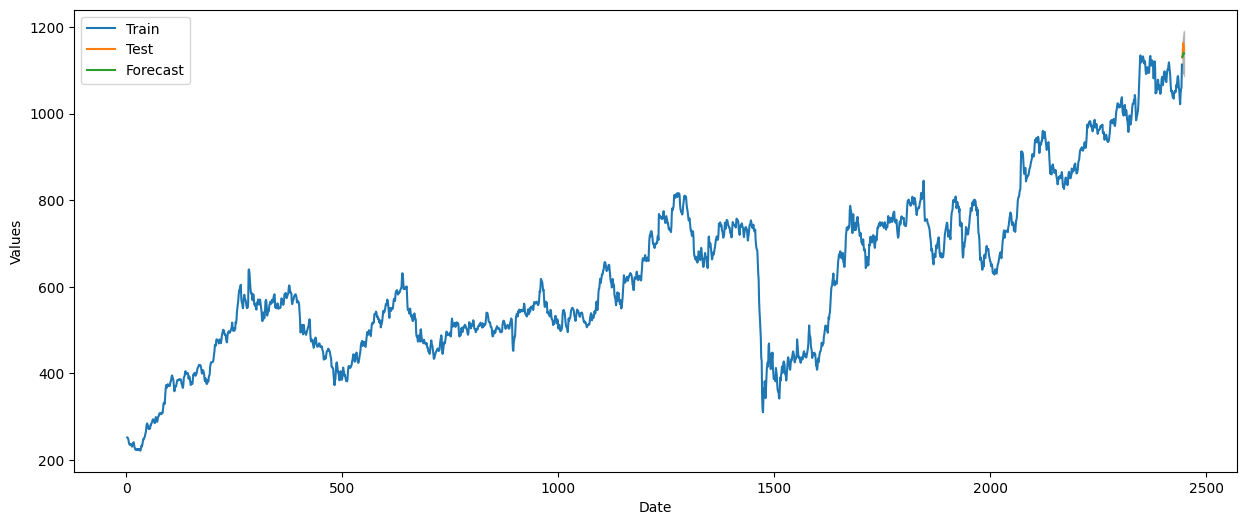

In [ ]:
# Define exogenous variables for testing
# exog_test = test[['lag_1', 'lag_2']]
exog_test = pd.DataFrame({'lag_1': mean_data.shift(1), 'lag_2': mean_data.shift(2)})
exog_test = exog_test.dropna()
exog_test = exog_test.iloc[-7:]

# Make predictions
pred = sarimax_result.get_prediction(start=test.index[0], end=test.index[-1], exog=exog_test)
pred_ci = pred.conf_int()

# Plot the results
ax = train['mean_data'].plot(label='Train', figsize=(15, 6))
test['mean_data'].plot(ax=ax, label='Test')
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)

ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()
plt.show()
